In [4]:
import numpy as np
import pandas as pd
from scipy.integrate import quad
import sys, os
import matplotlib.pyplot as plt
sys.path.append('..')
sys.path.append('../..')
import dcc
p = dcc.Parameters()

In [5]:
def q(l, lhat, p):
    """
    Q function from the text.
    Args:
        l: double
        lhat: double

    Returns: double
        q-value
    """
    with np.errstate(all='raise'):
        # there was a problem with numpy exp that does not handle well negative base with real exponents
        try:
            base = np.divide(lhat - p.lambdainf, l - p.lambdainf)
            exponent = (p.rho + p.lambdainf) / p.kappa
            res = lhat / (p.rho + lhat) * \
                  (np.sign(base) * np.abs(base) ** exponent) * np.exp((lhat - l) / p.kappa)
        except Exception:
            print('CAUGHT')
            base = np.divide(lhat - p.lambdainf, l - p.lambdainf)
            exponent = (p.rho + p.lambdainf) / p.kappa
            print(f'Problem in q. q={0}, '
                                  f'base ={base}, '
                                  f'exponent={exponent}.')
            res = 0
    return res

$Q(\lambda, \hat{\lambda})$ designates the $\mathbb{E}[e^{-\rho T}|\lambda(0) = \lambda] \times \mathbb{P}[T \geq \theta(\lambda, \hat{\lambda}]$

Text(0, 0.5, 'Q')

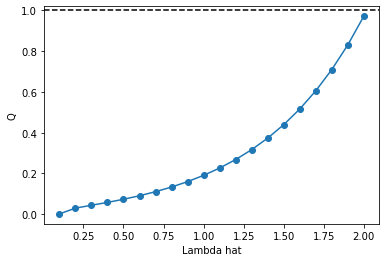

In [6]:
l = 2
lhats = np.linspace(p.lambdainf + 1e-6, l, 20)
qs = np.zeros_like(lhats)
for i, lhat in enumerate(lhats):
    qs[i] = q(l, lhat, p)

fig, ax = plt.subplots()
ax.plot(lhats, qs, marker='o')
ax.axhline(1, color='black', linestyle='--')
ax.set_xlabel('Lambda hat')
ax.set_ylabel('Q')

In [7]:
def integrand_disc_rep(l, lam, p):
    return q(lam, l, p) * np.divide(p.rho + l, p.kappa * (l - p.lambdainf))

def discounted_repayment(lam, lhat, p):
    return quad(integrand_disc_rep, lhat, lam, args=(lam, p))[0] + q(lam, lhat, p)
    

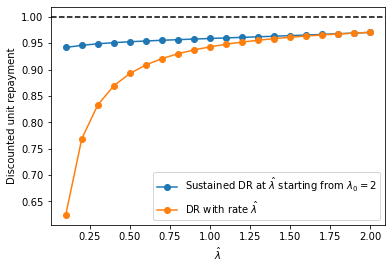

In [8]:
lambda_start = 2
lhats = np.linspace(p.lambdainf + 1e-6, lambda_start, 20)
dc_val = np.zeros_like(lhats)
dc_pois = np.zeros_like(lhats)
for i, lhat in enumerate(lhats):
    dc_val[i] = discounted_repayment(lambda_start, lhat, p)
    dc_pois[i] = lhat / (p.rho + lhat)

fig, ax = plt.subplots()
ax.plot(lhats, dc_val, marker='o')
ax.plot(lhats, dc_pois, marker='o')
ax.axhline(1, color='black', linestyle='--')
ax.set_xlabel(r'$\hat{\lambda}$')
ax.set_ylabel('Discounted unit repayment')
ax.legend(['Sustained DR at $\hat{\lambda}$ starting from $\lambda_0=2$', r'DR with rate $\hat{\lambda}$'])
assert dc_val[-1] - dc_pois[-1] == 0

At the limiting case where $\lambda = \hat{\lambda}$ we have to obtain a discounted unit repayment under homogenous poisson with rate $\lambda$, which is $\frac{\lambda}{\rho + \lambda}$.

It is straightforward to extend the the expectation for an arbitrary repayment as the rel. repayment distribution and distribution of arrival times are independent.

In [9]:
def integrand_disc_rep(l, lam, p):
    return q(lam, l, p) * np.divide(p.rho + l, p.kappa * (l - p.lambdainf))

def discounted_repayment(w, lam, lhat, p):
    return w * p.rmean * (quad(integrand_disc_rep, lhat, lam, args=(lam, p), limit=200)[0] + q(lam, lhat, p))

In [10]:
def theta(l, lhat, p):
    # equation for duration to reach a holding region
    try:
        numerator = (l - p.lambdainf)
        denominator = lhat - p.lambdainf

        if l < lhat:
            return 0
        elif denominator < 0:
            return np.NaN
        else:
            t = 1 / p.kappa * \
                np.log(numerator / denominator)
            return t
    except:
        print('warning')
        print(f'Numerator {(l - p.lambdainf)}')
        print(f'Denominator {lhat - p.lambdainf}')

In [11]:
def cont_costs(l, lhat, p):
    return p.chat * p.kappa * np.divide(lhat - p.lambdainf, lhat) * q(l, lhat, p)

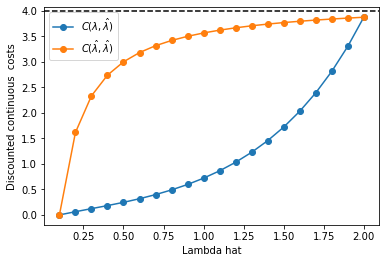

In [12]:
l = 2.0
lhats = np.linspace(p.lambdainf + 1e-6, l, 20)
dc_sust_costs = np.zeros_like(lhats)
dc_sust_costs_const = np.zeros_like(lhats)
for i, lhat in enumerate(lhats):
    dc_sust_costs[i] = cont_costs(l, lhat, p)
    dc_sust_costs_const[i] = cont_costs(lhat, lhat, p)
        
fig, ax = plt.subplots()
ax.plot(lhats, dc_sust_costs, marker='o')
ax.plot(lhats, dc_sust_costs_const, marker='o')
ax.axhline(4, color='black', linestyle='--')

ax.set_xlabel('Lambda hat')
ax.set_ylabel('Discounted continuous  costs')
ax.legend([r'$C(\lambda, \hat{\lambda})$', r'$C(\hat{\lambda}, \hat{\lambda})$'])

In [13]:
def greedy_v(w, l, lhat, p):
    if l >= lhat:
        v = - discounted_repayment(w, l, lhat, p) + cont_costs(l, lhat, p)
    else:
        v = + p.chat * (lhat - l)  + cont_costs(lhat, lhat, p) - discounted_repayment(w, lhat, lhat, p)
    return v    
    

In [14]:
def costs(l, lhat, p):
    if l >= lhat:
        sust_cost = cont_costs(l, lhat, p)
        jump_cost = 0
    else:
        sust_cost = + cont_costs(lhat, lhat, p) 
        jump_cost = + p.chat * (lhat - l)
    return sust_cost, jump_cost   

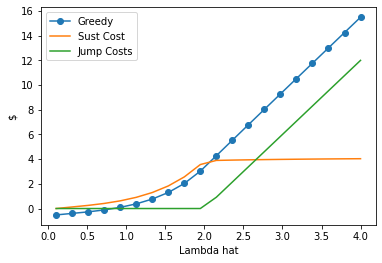

In [15]:
l = 2
w = 1
lhats = np.linspace(p.lambdainf + 1e-6, 4, 20)
v = np.zeros_like(lhats)
jump_costs = np.zeros_like(lhats)
sust_costs = np.zeros_like(lhats)
for i, lhat in enumerate(lhats):
    sust_cost, jump_cost= costs(l, lhat, p)
    v[i] = greedy_v(w, l, lhat, p)
    sust_costs[i] = sust_cost
    jump_costs[i] = jump_cost
    
fig, ax = plt.subplots()
ax.plot(lhats, v, marker='o')
ax.plot(lhats, sust_costs)
ax.plot(lhats, jump_costs)
ax.set_xlabel('Lambda hat')
ax.set_ylabel('$')
ax.legend(['Greedy', 'Sust Cost','Jump Costs'])

Behaviour as expected - for $\hat{\lambda} \geq \lambda$ the jump costs kick in. 

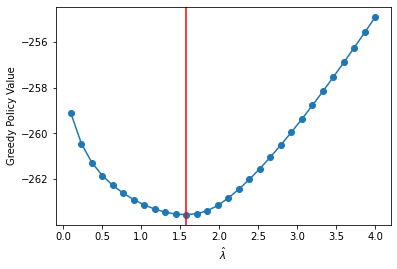

In [63]:
l = 2
w = 500
lhats = np.linspace(p.lambdainf + 1e-6, 4, 30)
v = np.zeros_like(lhats)
jump_costs = np.zeros_like(lhats)
sust_costs = np.zeros_like(lhats)
for i, lhat in enumerate(lhats):
    sust_cost, jump_cost= costs(l, lhat, p)
    v[i] = greedy_v(w, l, lhat, p)
fig, ax = plt.subplots()
ax.plot(lhats, v, marker='o')
ax.set_xlabel(r'$\hat{\lambda}$')
ax.set_ylabel('Greedy Policy Value')
index = np.argmin(v)
ax.axvline(lhats[index], color='red')

Given the smooth properties of the objective function we can reliably employ optimization techniques using gradient descent

In [17]:
from scipy.optimize import minimize
def objective_fun(lhat, w, l ,p):
    return greedy_v(w, l, lhat, p)
x0 = 1.0
res = minimize(objective_fun, x0, args=(w, l, p), bounds=[(p.lambdainf, None)])

In [18]:
res

      fun: array([-263.55772227])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([1.13686838e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 5
   status: 0
  success: True
        x: array([1.56419365])

In [19]:
res.x

array([1.56419365])

And putting this all together yields the ''greedy'' frontier

In [20]:
def calculate_greedy_frontier(wmax, p, points=40):
    ws = np.linspace(15, wmax, points)
    lambda_hats = np.zeros_like(ws)
    v_greedy = np.zeros_like(ws)
    x0 = np.array([1.0])
    l = 2.0
    for i, w in enumerate(ws):
        res = minimize(objective_fun, x0, args=(w, l, p), bounds=[(p.lambdainf, None)])
        v_greedy[i] = res.fun
        lambda_hats[i] = res.x
    return ws, lambda_hats, v_greedy

If the implementation is correct with increasing kappa the minimum actionable balance has to increase

In [21]:
import copy
p = dcc.Parameters()
p2 = copy.deepcopy(p)
p3 = copy.deepcopy(p)
p2.kappa = p.kappa * 2
p3.kappa = p.kappa * 3
ws, lhats, vs = calculate_greedy_frontier(300, p)
ws, lhats2, vs2 = calculate_greedy_frontier(300, p2)
ws, lhats3, vs3 = calculate_greedy_frontier(300, p3)

c:\users\majke\anaconda3\envs\tf2-gpu\lib\site-packages\ipykernel_launcher.py:5: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  """


Text(0, 0.5, 'Value')

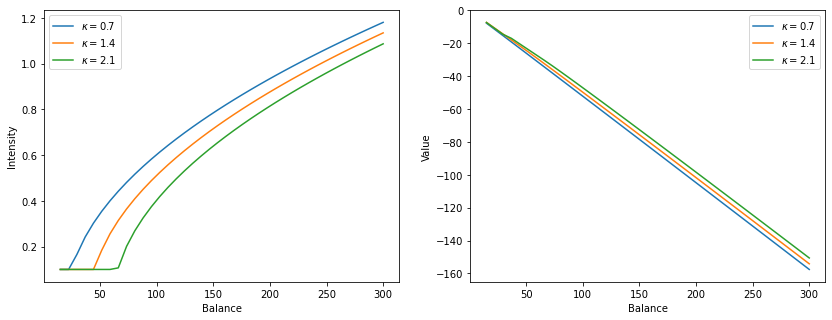

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].plot(ws, lhats)
ax[0].plot(ws, lhats2)
ax[0].plot(ws, lhats3)
ax[0].legend([r'$\kappa=0.7$', r'$\kappa=1.4$', r'$\kappa=2.1$'])
ax[0].set_xlabel('Balance')
ax[0].set_ylabel(r'Intensity')
ax[1].plot(ws, vs)
ax[1].plot(ws, vs2)
ax[1].plot(ws, vs3)
ax[1].legend([r'$\kappa=0.7$', r'$\kappa=1.4$', r'$\kappa=2.1$'])
ax[1].set_xlabel('Balance')
ax[1].set_ylabel('Value')

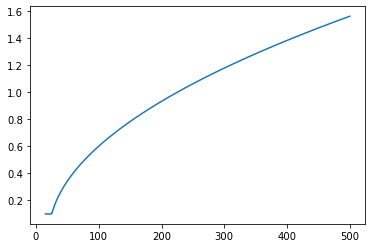

In [23]:
ws, lhats, vs = calculate_greedy_frontier(500, p, 100)
plt.plot(ws, lhats)

In [48]:
import osl

In [49]:
# BUILD ONLY FOR MY MAC

# mc500 = np.load('mc_100_samples_500usd.npy')
# from osl.mc.sustained_ihp import SustainedIHP
# sihp = SustainedIHP(500, p, lmax_profile=3, ws_points=100, niter=1e6)
# PATH_TO_PICKLE_500 = '/Users/mmark/Documents/credit_collections/credit_collections_rl/dcc/precomputed_w500'
# oc500 = dcc.OAV.load(PATH_TO_PICKLE_500)
# fig, ax = plt.subplots()
# ax.axhline(y=oc500.p.lambdainf, linestyle='-.', color='red')
# ax.axvline(x=oc500.w_, linestyle='--', color='yellow')
# ax.axvline(x=oc500.w0star, linestyle='--', color='green')
# for wstar in oc500.wistar[2:]:
#     ax.axvline(x=wstar, linestyle='--', color='black')

# h1 = ax.plot(oc500.w_vector, oc500.lambdastars)
# ax.set_ylim(bottom=0)
# ax.set_xlabel('Balance')
# ax.set_ylabel('Intensity')
# lstar_greedy = np.mean(np.array(mc500), 0)
# lstar_greedy_std = np.std(np.array(mc500), 0)
# ax.plot(sihp.ws, lstar_greedy, marker='x')
# ax.fill_between(sihp.ws,lstar_greedy-2*lstar_greedy_std, lstar_greedy+2*lstar_greedy_std, alpha=0.4, color='salmon')
# h2 = ax.plot(ws, lhats)
# ax.legend([h1[0], h2[0]], ['Holding region', 'Greedy'])

## Are they the same? 

[INFO] [2020-06-11 10:14:49,912] [AAV] - Instantiated @ AAV
[INFO] [2020-06-11 10:14:49,953] [OAV] - Launching the value function procedure.
[INFO] [2020-06-11 10:14:49,954] [OAV] - Computing the value function on (0.00, 100.10].
[INFO] [2020-06-11 10:14:49,995] [OAV] - Computing the value function on (100.10, 10009.90].


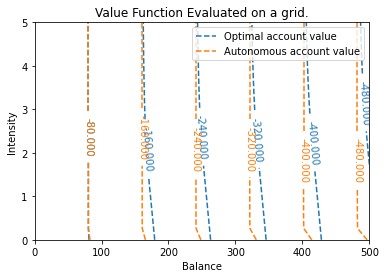

In [50]:
pfull = copy.deepcopy(p)
pfull.r_ = 0.99
w_start = 500
ws, lhatsr, vsr = calculate_greedy_frontier(w_start, pfull, 100)
oavfull = dcc.OAV(pfull, w_start, nx=200, ny=20, lmax=5)
oavfull.solve_v()
fig = oavfull.plot_vf(plot_aav_flag=True)

(0.0, 2.2584007903174146)

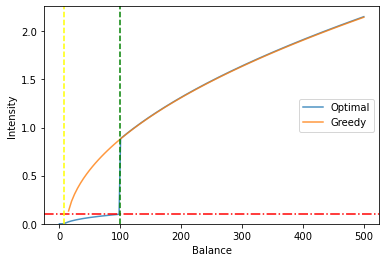

In [51]:
fig, ax = plt.subplots()
ax.plot(oavfull.w_vector, oavfull.lambdastars, alpha=0.8)
ax.plot(ws, lhatsr, alpha=0.8)
ax.legend(['Optimal', 'Greedy'])
ax.axhline(y=oavfull.p.lambdainf, linestyle='-.', color='red')
ax.axvline(x=oavfull.w_, linestyle='--', color='yellow')
ax.axvline(x=oavfull.w0star, linestyle='--', color='green',)
ax.set_xlabel('Balance')
ax.set_ylabel('Intensity')
ax.set_ylim(0, None)

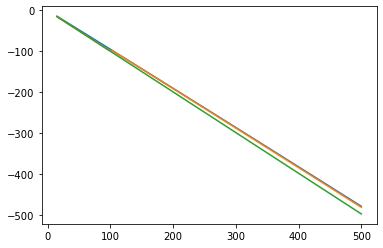

In [52]:
v_opt = np.zeros_like(ws)
u = np.zeros_like(ws)
lstart = 2.0
for i, w in enumerate(ws):
    v_opt[i] = oavfull.v(lstart, w)
    u[i] = oavfull.u(lstart, w)
plt.plot(ws, vsr)
plt.plot(ws, v_opt)
plt.plot(ws, u)

## Value the gap

[INFO] [2020-06-11 10:10:46,507] [AAV] - Instantiated @ AAV
[INFO] [2020-06-11 10:10:46,521] [OAV] - Launching the value function procedure.
[INFO] [2020-06-11 10:10:46,521] [OAV] - Computing the value function on (0.00, 16.83].
[INFO] [2020-06-11 10:10:46,529] [OAV] - Computing the value function on (16.83, 18.70].
[INFO] [2020-06-11 10:10:48,373] [OAV] - Computing the value function on (18.70, 20.78].
[INFO] [2020-06-11 10:10:49,460] [OAV] - Computing the value function on (20.78, 23.08].
[INFO] [2020-06-11 10:10:50,195] [OAV] - Computing the value function on (23.08, 25.65].
[INFO] [2020-06-11 10:10:50,935] [OAV] - Computing the value function on (25.65, 28.50].
[INFO] [2020-06-11 10:10:51,646] [OAV] - Computing the value function on (28.50, 31.66].
[INFO] [2020-06-11 10:10:52,257] [OAV] - Computing the value function on (31.66, 35.18].
[INFO] [2020-06-11 10:10:52,834] [OAV] - Computing the value function on (35.18, 39.09].
[INFO] [2020-06-11 10:10:53,517] [OAV] - Computing the valu

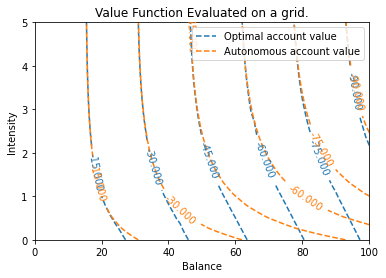

In [46]:
w_start = 100
oav = dcc.OAV(p, w_start, lmax=5)
oav.solve_v()
fig = oav.plot_vf(plot_aav_flag=True)

In [59]:
oav.v(0.11,100)

array([[-78.1347436]])

In [61]:
oav_greedy.v(0.11, 100)

array([[-75.13960737]])

(0.0, 500.0)

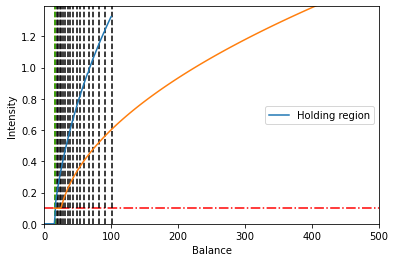

In [54]:
fig, ax = plt.subplots()
ax.axhline(y=oav.p.lambdainf, linestyle='-.', color='red')
ax.axvline(x=oav.w_, linestyle='--', color='yellow')
ax.axvline(x=oav.w0star, linestyle='--', color='green')
for wstar in oav.wistar[2:]:
    ax.axvline(x=wstar, linestyle='--', color='black')

h1 = ax.plot(oav.w_vector, oav.lambdastars)
ax.set_ylim(bottom=0)
ax.set_xlabel('Balance')
ax.set_ylabel('Intensity')
ax.legend([h1[0]], ['Holding region'])
lstar_greedy = np.mean(np.array(mc500), 0)
lstar_greedy_std = np.std(np.array(mc500), 0)
# BUILD ONLY ON MY MAC
# ax.plot(sihp.ws, lstar_greedy, marker='x')
# ax.fill_between(sihp.ws,lstar_greedy-2*lstar_greedy_std, lstar_greedy+2*lstar_greedy_std, alpha=0.4, color='salmon')
ax.plot(ws, lhats)
ax.set_xlim(0,500)

(0.0, 500.0)

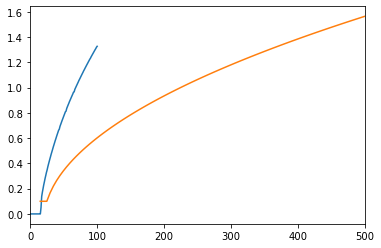

In [55]:
fig, ax = plt.subplots()
ax.plot(oav.w_vector, oav.lambdastars)
ax.plot(ws, lhats)
ax.set_xlim(0, 500)


In [56]:
w_grid = np.linspace(0, 500, 40)
v_opt = np.zeros_like(w_grid)
v_greedy = np.zeros_like(w_grid)
v_aut = np.zeros_like(w_grid)
u = np.zeros_like(w_grid)
lstart = 2.0
for i, w in enumerate(w_grid):
    v_opt[i] = oav.v(lstart, w)
    v_aut[i] = oav.u(lstart, w)
    res = minimize(objective_fun, w, args=(w, lstart, p), bounds=[(p.lambdainf, None)])
    v_greedy[i] = greedy_v(w, l, res.x, p)
    

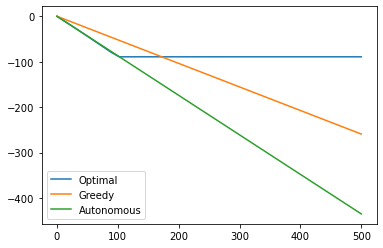

In [57]:
fig, ax = plt.subplots()
ax.plot(w_grid, v_opt)
ax.plot(w_grid, v_greedy)
ax.plot(w_grid, v_aut)
ax.legend(['Optimal', 'Greedy', 'Autonomous'])

In [58]:
def greedy_policy(w):
    index = np.digitize(w, ws, right=True)
    return lhats[index]
greedy_policy(400)

1.3888291202519332

In [36]:
from dcc.aav import AAV, Parameters
from dcc.base import Base
import numpy as np
from scipy.optimize import fsolve, brentq
from scipy import integrate
from scipy.interpolate import RectBivariateSpline
import matplotlib.pyplot as plt
import pickle


class OAVArb(Base):
    """
    Instance of the controlled Collection process as per Chehrazi, Weber & Glyn 2019
    “Dynamic Credit-Collections Optimization”.
    The value function is constructed in an itterative manner using bivariate interpolation.
    """

    def __init__(self, p, balance, policy, nx=100, ny=20, lmax=2):
        """
        Standard Class initialization.
        Args:
            p: class Parameters
            balance: double
                starting balance
            lstart: double
                starting intensity
            nx: int or np.ndarray(dim=1)
                number of grid discretizations in balance space
            ny: int or np.ndarray(dim=1)
                number of grid discretizations in lamdba space
            lmax: double
                upper bound of the lambda for discretization.
        """
        super().__init__(__class__.__name__)
        self.policy = policy
        self.v = None
        self.p = p
        self.balance = balance
        self.aavc = AAV(p)
        self.u = self.aavc.u
        self.w_ = self.aavc.w_
        self.w0star = self.aavc.w0star
        self.iw = self.comp_iw()
        self.wistar = self.comp_wistar()

        # Grid specifications
        # The value function is computed in an iterative manner on a given discretized grid:
        self.nx = nx
        self.ny = ny
        if isinstance(nx, int) and isinstance(ny, int):
            self.lambdas_vector = np.linspace(0, lmax, self.ny)
            self.w_vector = np.linspace(0, balance, self.nx)
        elif isinstance(nx, np.ndarray) and isinstance(ny, np.ndarray):
            self.w_vector = nx
            self.lambdas_vector = ny
        self.xx, self.yy = np.meshgrid(self.w_vector, self.lambdas_vector)
        self.zz = np.zeros_like(self.xx)
        self.lambdastars = np.zeros_like(self.w_vector)

        # r integration grid for v bar
        self._r_grid = np.linspace(self.p.r_, 1 - 10e-16, 40)

    def comp_wistar(self):
        # TODO: When instance is reinitialized with new balance this should be auto recomputed.
        wiarray = np.cumsum(np.ones(self.iw))
        wiarray = self.w0star * np.power(1 - self.p.r_, -wiarray)
        wiarray = np.insert(wiarray, 0, self.w0star)
        wiarray = np.insert(wiarray, 0, 0)
        return wiarray

    def comp_iw(self):
        # TODO: When instance is reinitialized with new balance this should be auto recomputed.
        iwret = np.ceil(np.log(self.aavc.w0star / self.balance) / np.log(1 - self.p.r_)).astype(int)
        return iwret

    def v0star_arb(self, l, w, lstar=None):
        """
        Computes the v0star. For balances smaller than minimal actionable balance this coincides with u(l, w).
        Args:
            l: double
                intensity to be evaluated at
            w: double
                balance to be evaluated at
            lstar: double (optional)
                optimal sustain level given by lambdastar0 equation, if not provided function computes it
                on its own.

        Returns: double
            terminal value of a given account
        """

        if w < self.w_:
            v = self.aavc.u(l, w)
        else:
            if lstar is None:
                lstar = self.policy(w)
            if l > lstar:
                v = self.aavc.u(l, w)
            else:
                astar = (lstar - l) / self.p.delta2
                v = self.aavc.u(l + astar * self.p.delta2, w) + astar * self.p.c
        return v

    def q(self, l, lhat):
        """
        Q function from the text.
        Args:
            l: double
            lhat: double

        Returns: double
            q-value
        """
        with np.errstate(all='raise'):
            # there was a problem with numpy exp that does not handle well negative base with real exponents
            try:
                base = np.divide(lhat - self.p.lambdainf, l - self.p.lambdainf)
                exponent = (self.p.rho + self.p.lambdainf) / self.p.kappa
                res = lhat / (self.p.rho + lhat) * \
                      (np.sign(base) * np.abs(base) ** exponent) * np.exp((lhat - l) / self.p.kappa)
            except Exception:
                print('CAUGHT')
                base = np.divide(lhat - self.p.lambdainf, l - self.p.lambdainf)
                exponent = (self.p.rho + self.p.lambdainf) / self.p.kappa
                self.logger.exception(f'Problem in q. q={0}, '
                                      f'base ={base}, '
                                      f'exponent={exponent}.')
                res = 0
        return res

    def evaluate_v_arb(self, vstar, wi):
        """
        Evaluates the value function up to known wistar on a prespecified grid.
        Args:
            vstar: value funnction to be evaluated
            wi: order of wistar

        Returns: np.ndarray(dim=2)
            Value function evaluated on the grid specified in __init__.
        """

        for j, x in enumerate(self.w_vector):
            if self.wistar[wi] < x <= self.wistar[wi+1]:
                lambdastar = 0.0
                if wi >= 1:
                    lambdastar = self.policy(x)
                if wi == 0:
                    if x > self.w_:
                        lambdastar = self.policy(x)
                self.lambdastars[j] = lambdastar
                for i, y in enumerate(self.lambdas_vector):
                    if wi >= 1:
                        self.zz[i, j] = self.sustain_operator(vstar, y, x, lambdastar)
                    elif wi == 0:
                        self.zz[i, j] = self.v0star_arb(y, x, lambdastar)
                    else:
                        raise IndexError('Something wrong with the iteration')
        return self.zz



    def interpolate_known_v(self):
        interpolator = RectBivariateSpline(self.lambdas_vector, self.w_vector, self.zz)
        return interpolator

    def plot_interpolator(self):
        interpolator = self.interpolate_known_v()
        zz = interpolator(self.lambdas_vector, self.w_vector)
        fig, ax = plt.subplots()
        CS = ax.contour(self.xx, self.yy, zz)
        ax.clabel(CS, inline=1, fontsize=10)
        ax.set_title('Interpolated Value Function')
        fig.show()

    def sustain_operator(self, v, lam, w, lhat):
        res = 0
        if lam >= lhat:
            def integrand(l):
                return self.vbar(v, l, w) * self.q(lam, l) * \
                       np.divide(l + self.p.rho, self.p.kappa * (l - self.p.lambdainf))

            y, err = integrate.quad(integrand, lhat, lam)
            res = y + (self.vbar(v, lhat, w) + self.p.chat * \
                       self.p.kappa * np.divide(lhat - self.p.lambdainf, lhat)) * self.q(lam, lhat)
        else:
            res = self.p.chat * (lhat - lam) + (self.vbar(v, lhat, w) + self.p.chat * \
                                                self.p.kappa * np.divide(lhat - self.p.lambdainf, lhat)) * self.q(lhat,
                                                                                                                  lhat)
        return res

    def solve_v(self, plot_progression_flag: bool=False):
        """
        Iteratively solves the value function.
        Args:
            plot_progression_flag: bool
                plots the iterative progregression of the v.f. approximation

        Returns: None

        """
        self.logger.info('Launching the value function procedure.')
        v_current = self.v0star_arb
        for wi, wval in enumerate(self.wistar[:-1]):
            self.logger.info(f'Computing the value function on ({self.wistar[wi]:.2f}, {self.wistar[wi+1]:.2f}].')
            self.evaluate_v_arb(v_current, wi)
            # for plotting the iterative progress of the value function uncomment the following line
            if plot_progression_flag:
                self.plot_vf().show()
            v_current = self.interpolate_known_v()
            # self.plot_interpolator()
            # if wi > 1:
            #     w_test = np.linspace(wval, self.balance, 20)
            #     vals = np.zeros_like(w_test)
            #     for i ,singlew in enumerate(w_test):
            #         vals[i] = self.fi(v_current, singlew)
            #     plt.plot(w_test, vals, marker = 'x')
            #     plt.show()
            # v_current = lambda l, w: self.extended_value_function(l, w, interpolated)
        self.v = v_current
        pass

    def vbar(self, v, l, w):
        def I(r): return self.p.rdist(r) * (v(l + self.p.delta10 + self.p.delta11 * r, (1 - r) * w) - r * w)

        valgrid = np.array([I(r) for r in self._r_grid]).flatten()
        res = integrate.trapz(valgrid, self._r_grid)
        return res

    def plot_statespace(self):
        '''
        Plots the statespace together with the optimal frontier
        Args:
            warr:

        Returns:

        '''
        fig, ax = plt.subplots()
        ax.axhline(y=self.p.lambdainf, linestyle='-.', color='red')
        ax.axvline(x=self.w_, linestyle='--', color='yellow')
        ax.axvline(x=self.w0star, linestyle='--', color='green')
        for wstar in self.wistar[2:]:
            ax.axvline(x=wstar, linestyle='--', color='black')

        h1 = ax.plot(self.w_vector, self.lambdastars)
        ax.set_ylim(bottom=0)
        ax.set_xlabel('Balance')
        ax.set_ylabel('Intensity')
        ax.legend([h1[0]], ['Holding region'])
        return fig

    def plot_vf(self, plot_aav_flag=False):
        """
        Contour plot of the value function for the grid setup in __init__
        Args:
            plot_aav_flag: pot also the autonomous account value

        Returns: figure handle
            fig
        """
        fig, ax = plt.subplots()
        cntr1 = ax.contour(self.xx, self.yy, self.zz, colors='C0')
        ax.clabel(cntr1, inline=1, fontsize=10)
        if plot_aav_flag:
            xx_dump, yy_dump, zz_aav = self.aavc.evaluate_aav(self.lambdas_vector, self.w_vector)
            cntr2 = ax.contour(self.xx, self.yy, zz_aav, colors='C1')
            ax.clabel(cntr2, inline=1, fontsize=10)
            h1, _ = cntr1.legend_elements()
            h2, _ = cntr2.legend_elements()
            ax.legend([h1[0], h2[0]], ['Optimal account value', 'Autonomous account value'])
        else:
            h1, _ = cntr1.legend_elements()
            ax.legend([h1[0]], ['Optimal account value'])
        ax.set_title('Value Function Evaluated on a grid.')
        ax.set_ylabel('Intensity')
        ax.set_xlabel('Balance')
        return fig

    def save(self, filename):
        f_name = filename + '.pickle'
        with open(f_name, "wb") as file_:
            pickle.dump(self, file_, -1)

    @classmethod
    def load(cls, f):
        with open(f + '.pickle', 'rb') as pickle_file:
            return pickle.load(pickle_file)

In [38]:
oav_greedy = OAVArb(p,100, greedy_policy)
oav_greedy.solve_v()

[INFO] [2020-06-11 10:06:45,757] [AAV] - Instantiated @ AAV
[INFO] [2020-06-11 10:06:45,773] [OAVArb] - Launching the value function procedure.
[INFO] [2020-06-11 10:06:45,774] [OAVArb] - Computing the value function on (0.00, 16.83].
[INFO] [2020-06-11 10:06:45,783] [OAVArb] - Computing the value function on (16.83, 18.70].
[INFO] [2020-06-11 10:06:53,061] [OAVArb] - Computing the value function on (18.70, 20.78].
[INFO] [2020-06-11 10:07:01,216] [OAVArb] - Computing the value function on (20.78, 23.08].
[INFO] [2020-06-11 10:07:08,913] [OAVArb] - Computing the value function on (23.08, 25.65].
[INFO] [2020-06-11 10:07:18,009] [OAVArb] - Computing the value function on (25.65, 28.50].
[INFO] [2020-06-11 10:07:20,869] [OAVArb] - Computing the value function on (28.50, 31.66].
[INFO] [2020-06-11 10:07:23,122] [OAVArb] - Computing the value function on (31.66, 35.18].
[INFO] [2020-06-11 10:07:24,521] [OAVArb] - Computing the value function on (35.18, 39.09].
[INFO] [2020-06-11 10:07:26,5

In [40]:
w_grid = np.linspace(0, 500, 40)
v_opt = np.zeros_like(w_grid)
v_greedy = np.zeros_like(w_grid)
v_aut = np.zeros_like(w_grid)
u = np.zeros_like(w_grid)
lstart = 2.0
for i, w in enumerate(w_grid):
    v_opt[i] = oav.v(lstart, w)
    v_aut[i] = oav.u(lstart, w)
    v_greedy[i] = oav_greedy.v(lstart, w)

NameError: name 'oav' is not defined

Text(0, 0.5, 'Value')

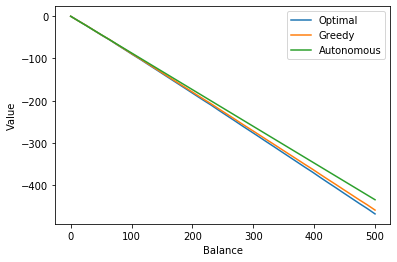

In [38]:
fig, ax = plt.subplots()
ax.plot(w_grid, v_opt)
ax.plot(w_grid, v_greedy)
ax.plot(w_grid, v_aut)
ax.legend(['Optimal', 'Greedy', 'Autonomous'])
ax.set_xlabel('Balance')
ax.set_ylabel('Value')

Text(0.5, 0, 'Relative error')

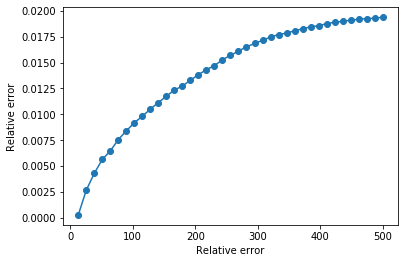

In [47]:
fig, ax = plt.subplots()
ax.plot(w_grid[1:], (np.abs((v_greedy-v_opt))/np.abs(v_opt))[1:], marker='o')
ax.set_ylabel(r'Relative error')
ax.set_xlabel('Relative error')

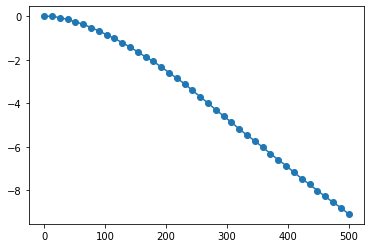

In [43]:
plt.plot(w_grid, v_opt - v_greedy, marker='o')